In [1]:
%matplotlib widget
import numpy as np
import scipy
import obspy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterMathtext
from scipy.signal import spectrogram
import datetime

In [2]:
# set path and data parameters
path = "/media/Data/Data/PIG/"
stat = "PIG*"
chans = "HH*"

# set path to XML response file
pathXML = path + "XML/" + chans + "/*" + stat + ".xml"
inv = obspy.read_inventory(pathXML)

In [ ]:
'''

Read data, remove instrumental response, and basic preprocessing for entire window constrained by TerraSAR-X data

'''

# set day of interest
year = "2012"
month = "05"
days = ["08","09","10","11"]

# read in traces without instrument response removed
files = [path + "MSEED/raw/" + stat + "/" + chans + "/*" + chans + "__" + year + month + day + "T000000Z__" + "*" for day in days]

# read in raw data
st_raw = obspy.Stream()
for f in files:
    st_raw += obspy.read(f)

# merge streams from corresponding stations and channels
st_raw.merge()
    
# basic preprocessing
st_raw.detrend("demean")
st_raw.detrend("linear")
st_raw.taper(max_percentage=0.00025, max_length=20.)

# remove response to lowest desired frequency
st_100000s = st_raw.copy().remove_response(inventory=inv,pre_filt=[0.000005,0.00001,45,50],output="VEL")

# save full-resolution data
st_event = st_100000s.copy().trim(starttime=obspy.UTCDateTime(2012,5,9,17),endtime=obspy.UTCDateTime(2012,5,9,23,59))
st_event.write("data/MSEED/may_9_event_velocity_100000s.MSEED")
st_100000s.write("data/MSEED/may_8-11_velocity_100000s.MSEED")

# save downsampled data
st_100000s_downsampled = st_100000s.resample(1)
st_100000s_downsampled.write("data/MSEED/may_8-11_velocity_100000s_downsampled.MSEED")
st_raw_downsampled = st_raw.resample(1)
st_raw_downsampled.write("data/MSEED/may_8-11_velocity_raw_downsampled.MSEED")

In [ ]:
'''

Make interactive plot for comparing data across stations and channels

'''

# get data
st_100000s = obspy.read("data/MSEED/may_8-11_velocity_100000s_downsampled.MSEED")
st_raw = obspy.read("data/MSEED/may_8-11_velocity_raw_downsampled.MSEED")

# set low cut period of data to be dispayed along with raw data
freq = [100,10000]

# put data into dictionary
window_start = obspy.UTCDateTime(2012,5,8,10,18)
window_end = obspy.UTCDateTime(2012,5,11,3,13)
data_dict = {}
for tr in st_raw:
    key = tr.stats.station+tr.stats.channel+"raw"
    data_dict[key] = tr.trim(starttime=window_start,endtime=window_end).data*1000
for tr in st_100000s:
    for f in freq: 
        key = tr.stats.station+tr.stats.channel+str(f)
        tr_filt = tr.copy().filter("highpass",freq=1/f)
        data_dict[key] = tr_filt.trim(starttime=window_start,endtime=window_end).data*1000

# get time vector
t = st_raw[1].times(type="matplotlib")

# make plot
nrows = len(freq)+2
ncols = 3
fig,ax = plt.subplots(nrows,ncols,figsize=[18,10])
plt.subplots_adjust(bottom=0.2)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# plot instrumental response
inv = obspy.read_inventory("data/XML/*.XML")
sampling_rate = 100
min_freq = 1/max(freq)
nfft = int(sampling_rate / min_freq)
response = inv.select(channel="HHZ",station="PIG2")[0][0][0].response
cpx_response, freq_vector = response.get_evalresp_response(t_samp=1/sampling_rate, nfft=nfft)
ax[0][0].loglog(1/freq_vector,abs(cpx_response),'k')
ax[0][0].set(title="Instrument Response")
ax[0][0].set_xlabel("Period (s)")
ax[0][0].set_ylabel("Amplitiude")
ax[0][0].invert_xaxis()
box = ax[0][0].get_position()
box.y0 = box.y0 + 0.075
box.y1 = box.y1 + 0.075
ax[0][0].set_position(box)
ax[0][1].set_visible(0)
ax[0][2].set_visible(0)

# plot the data and set labels
for j in range(3):
    for i in range(1,nrows):
        if i == 1:
            key = "PIG2HHZraw"
            ax[i][j].set_title("PIG2 HHZ\n\nRaw",y=0.8)
            ax[i][j].get_xaxis().set_ticklabels([])
            ax[1][0].set_ylabel("Counts")
        elif i == nrows-1:
            key = "PIG2HHZ"+str(freq[i-2])
            ax[i][j].set_title(">"+str(freq[i-2])+"s",y=0.8)
            ax[i][j].set_xlabel("Time")
            ax[i][j].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M'))
            ax[i][0].set_ylabel("Velocity (mm/s)")
        else:
            key = "PIG2HHZ"+str(freq[i-2])
            ax[i][j].set_title(">"+str(freq[i-2])+"s",y=0.8)
            ax[i][j].get_xaxis().set_ticklabels([])
            ax[i][0].set_ylabel("Velocity (mm/s)")
        ax[i][j].plot(t,data_dict[key],lw=2,color=colors[i-1])
        ax[i][j].set_xlim([t[0],t[-1]])
        ax[nrows-1][j].get_shared_x_axes().join(ax[nrows-1][j],ax[i][j])

# define object for updating data when buttons are pressed
class metadata:
    def __init__(self,station,channel,column):
        self._station = station
        self._channel = channel
        self._column = column

    def select_component(self,component_id,component_type):
        def clicked(event):
            if component_type == "station":
                self._station = component_id
            if component_type == "channel":
                self._channel = component_id
            for i in range(nrows-1):
                if i == 0:
                    key = self._station+self._channel+"raw"
                    ax[i+1][self._column].set_title(self._station+" "+self._channel+"\n\nRaw",y=0.8)
                else:
                    key = self._station+self._channel+str(freq[i-1])
                ax[i+1][self._column].get_lines()[0].set_ydata(data_dict[key])
            for axis in ax.transpose()[self._column][1:]:
                axis.relim()
                axis.autoscale()
                axis.set_xlim([t[0],t[-1]])
            plt.draw()
        return clicked
        
# make instances of the widget
column0 = metadata("PIG2","HHZ",0)
column1 = metadata("PIG2","HHZ",1)
column2 = metadata("PIG2","HHZ",2)

# add each set of buttons
axbutton = plt.axes([0.125, 0.075, 0.05, 0.05])
pig2_b0 = Button(axbutton, 'PIG2')
pig2_b0.on_clicked(column0.select_component("PIG2","station"))
axbutton = plt.axes([0.2, 0.075, 0.05, 0.05])
pig4_b0 = Button(axbutton, 'PIG4')
pig4_b0.on_clicked(column0.select_component("PIG4","station"))
axbutton = plt.axes([0.275, 0.075, 0.05, 0.05])
pig5_b0 = Button(axbutton, 'PIG5')
pig5_b0.on_clicked(column0.select_component("PIG5","station"))
plt.text(-4,0.4,"Stations")
axbutton = plt.axes([0.125, 0.01, 0.05, 0.05])
hhz_b0 = Button(axbutton, 'HHZ')
hhz_b0.on_clicked(column0.select_component("HHZ","channel"))
axbutton = plt.axes([0.2, 0.01, 0.05, 0.05])
hhn_b0 = Button(axbutton, 'HHN')
hhn_b0.on_clicked(column0.select_component("HHN","channel"))
axbutton = plt.axes([0.275, 0.01, 0.05, 0.05])
hhe_b0 = Button(axbutton, 'HHE')
hhe_b0.on_clicked(column0.select_component("HHE","channel"))
plt.text(-4,0.4,"Channels")

# second set of buttons
axbutton = plt.axes([0.125+0.275, 0.075, 0.05, 0.05])
pig2_b1 = Button(axbutton, 'PIG2')
pig2_b1.on_clicked(column1.select_component("PIG2","station"))
axbutton = plt.axes([0.2+0.275, 0.075, 0.05, 0.05])
pig4_b1 = Button(axbutton, 'PIG4')
pig4_b1.on_clicked(column1.select_component("PIG4","station"))
axbutton = plt.axes([0.275+0.275, 0.075, 0.05, 0.05])
pig5_b1 = Button(axbutton, 'PIG5')
pig5_b1.on_clicked(column1.select_component("PIG5","station"))
axbutton = plt.axes([0.125+0.275, 0.01, 0.05, 0.05])
hhz_b1 = Button(axbutton, 'HHZ')
hhz_b1.on_clicked(column1.select_component("HHZ","channel"))
axbutton = plt.axes([0.2+0.275, 0.01, 0.05, 0.05])
hhn_b1 = Button(axbutton, 'HHN')
hhn_b1.on_clicked(column1.select_component("HHN","channel"))
axbutton = plt.axes([0.275+0.275, 0.01, 0.05, 0.05])
hhe_b1 = Button(axbutton, 'HHE')
hhe_b1.on_clicked(column1.select_component("HHE","channel"))

# third set of buttons
axbutton = plt.axes([0.125+2*(0.275), 0.075, 0.05, 0.05])
pig2_b2 = Button(axbutton, 'PIG2')
pig2_b2.on_clicked(column2.select_component("PIG2","station"))
axbutton = plt.axes([0.2+2*(0.275), 0.075, 0.05, 0.05])
pig4_b2 = Button(axbutton, 'PIG4')
pig4_b2.on_clicked(column2.select_component("PIG4","station"))
axbutton = plt.axes([0.275+2*(0.275), 0.075, 0.05, 0.05])
pig5_b2 = Button(axbutton, 'PIG5')
pig5_b2.on_clicked(column2.select_component("PIG5","station"))
axbutton = plt.axes([0.125+2*(0.275), 0.01, 0.05, 0.05])
hhz_b2 = Button(axbutton, 'HHZ')
hhz_b2.on_clicked(column2.select_component("HHZ","channel"))
axbutton = plt.axes([0.2+2*(0.275), 0.01, 0.05, 0.05])
hhn_b2 = Button(axbutton, 'HHN')
hhn_b2.on_clicked(column2.select_component("HHN","channel"))
axbutton = plt.axes([0.275+2*(0.275), 0.01, 0.05, 0.05])
hhe_b2 = Button(axbutton, 'HHE')
hhe_b2.on_clicked(column2.select_component("HHE","channel"))

plt.show()

In [ ]:
'''

Make spectrogram of the event

'''

# set parameters
station = "PIG2"
channel = "HHN"
low_cut = 1000

# read data
st = obspy.read("data/MSEED/may_9_event_velocity_100000s.MSEED")
st = st.trim(starttime=obspy.UTCDateTime(2012,5,9,17),endtime=obspy.UTCDateTime(2012,5,9,21))

# make plot
fig,ax = plt.subplots(2,1,figsize=[10,10],gridspec_kw={'height_ratios': [1, 3]})

# plot data
times = [t.datetime for t in st[2].times("UTCDateTime")]
ticks = [times[len(times)//8],times[len(times)//4],times[len(times)//8*3],times[len(times)//2],times[len(times)//8*5],times[len(times)//4*3],times[len(times)//8*7],times[len(times)-1]]
ax[0].plot(times,st.select(channel=channel,station=station)[0].filter("highpass",freq=1/low_cut).data*1000,'k')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[0].grid(True)
box = ax[0].get_position()
box.y0 = box.y0 - 0.1
box.y1 = box.y1 - 0.1
ax[0].set_position(box)
ax[0].set_ylabel("Velocity (mm/s)")    
ax[0].set_title(station+" "+channel)

# make spectrogram
f,t,s = spectrogram(st.select(station=station,channel=channel)[0].data*1000, fs=100.0, nperseg=30000)

# plot spectrogram 
times = [datetime.datetime(2012,5,9,17) + datetime.timedelta(seconds=time) for time in t]
vrange = np.log10(np.max(s))-np.log10(np.min(s))
spec = ax[1].pcolor(times, np.log10(f), np.log10(s), vmin=np.log10(np.min(s))+vrange*0.5,vmax=np.log10(np.max(s)))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[1].get_shared_x_axes().join(ax[0],ax[1])
ax[1].set_xticks(ticks)
ax[1].set_xlim([times[0],times[-1]])
ax[1].set_yticks([-2.3,-2,-1,0,1])
ax[1].set_yticklabels(["","$10^{-2}$","$10^{-1}$","$10^{0}$","$10^{1}$"])
ax[1].set_ylabel("Frequency (Hz)")
ax[1].set_xlabel("Time")
plt.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.1225, 0.025, 0.5])
cbar = plt.colorbar(spec,label="PSD (mm$^2$/Hz)",ticks=[-10,-8,-6,-4,-2,0],cax=cbar_ax)
cbar.ax.set_yticklabels(['$10^{-10}$', '$10^{-8}$', '$10^{-6}$', '$10^{-4}$','$10^{-2}$','$10^0$']) 
plt.savefig(station + "_" + channel + "_spectrogram.png")

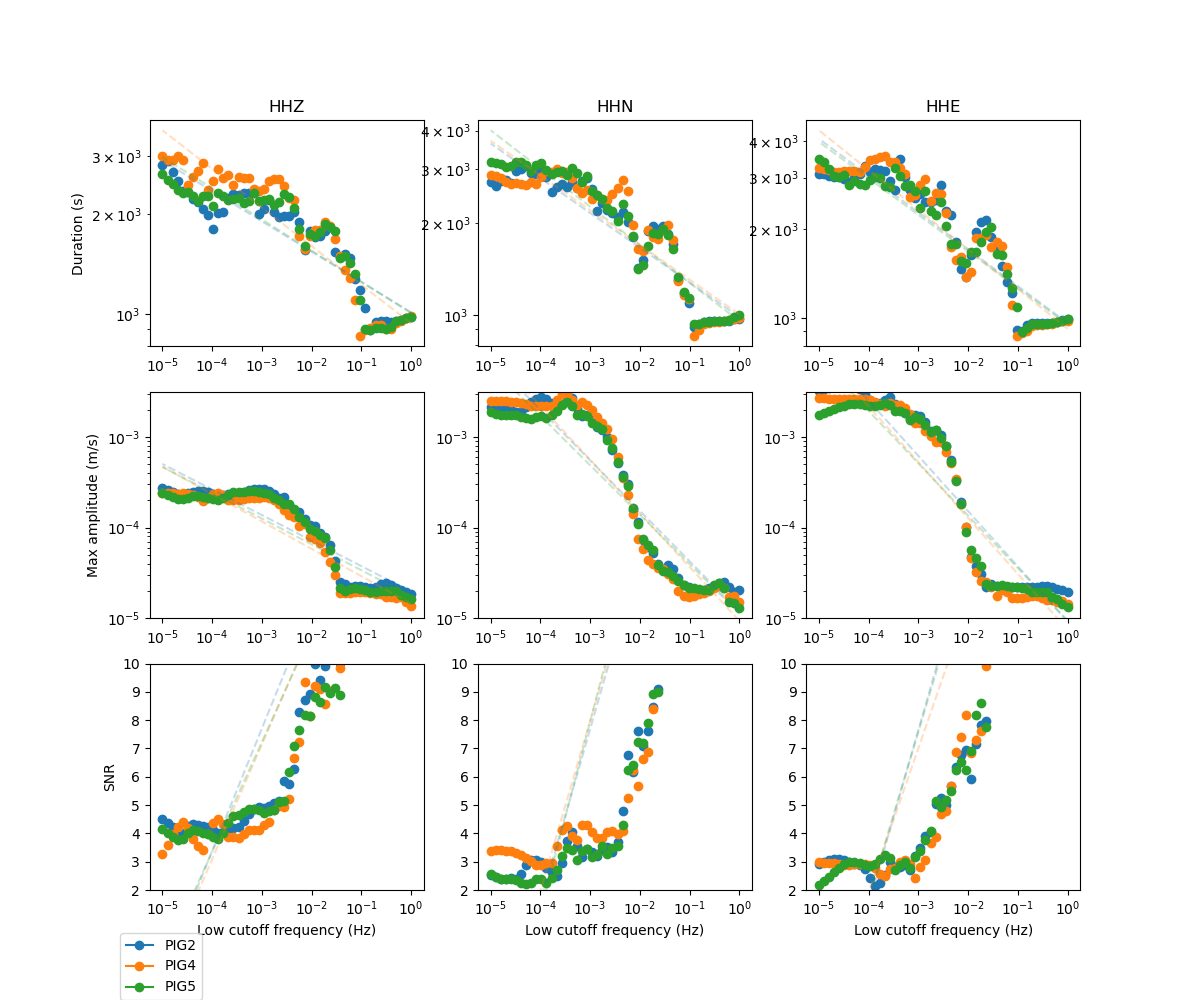

In [157]:
'''

Investigate relationships between frequency and duration, SNR, and amplitude

'''

# get data
st = obspy.read("data/MSEED/may_9_event_velocity_100000s.MSEED")

# set parameters 
stations = ["PIG2","PIG4","PIG5"]
channels = ["HHZ","HHE","HHN"]
low_cut = np.logspace(0,5)

low_freq = 1/low_cut
fs = 100
window_start = obspy.UTCDateTime(2012,5,9,18,2)
window_end = obspy.UTCDateTime(2012,5,9,20)
#window_end = [obspy.UTCDateTime(2012,5,9,18,10),obspy.UTCDateTime(2012,5,9,18,10),obspy.UTCDateTime(2012,5,9,18,40),
#              obspy.UTCDateTime(2012,5,9,20),obspy.UTCDateTime(2012,5,9,20),obspy.UTCDateTime(2012,5,9,20)]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# put data into dictionary
data_dict = {}
for tr in st:
    for f in range(len(low_cut)): 
        key = tr.stats.station+tr.stats.channel+str(low_cut[f])
        tr_filt = tr.copy().filter("highpass",freq=low_freq[f])
        data_dict[key] = tr_filt.trim(starttime=window_start,endtime=window_end).data
    
# make functions that estimate each parameter of interest
def get_duration(data,fs):
    env = np.abs(scipy.signal.hilbert(data))
    sos = scipy.signal.butter(2,0.001, 'lp', fs=fs, output='sos')
    filt_env = scipy.signal.sosfilt(sos, env)
    filt_env_diff = np.diff(filt_env)/(1/fs)
    filt_env_diff_abs = np.abs(filt_env_diff)
    thresh = np.mean(filt_env_diff_abs)
    duration = len(data)-np.sum([filt_env_diff_abs<thresh])
    return duration/fs

def get_snr(data):
    snr = get_amplitude(data)/data.std()
    return snr

def get_amplitude(data):
    amplitude = np.max(np.abs(data))
    return amplitude

def regression(model_vector,data_vector):
    model_vector = np.vstack((np.array(model_vector),np.ones((len(model_vector))))).transpose()
    m,b = np.linalg.lstsq(model_vector,data_vector,rcond=None)[0]
    return m,b

# make plot 
fig,ax = plt.subplots(3,3,figsize=[12,10])
for axes in ax:
    for axis in axes:
        axis.set_xscale('log')
for axes in ax[:2]:
    for axis in axes:
        axis.set_yscale('log')
        
# iterate through each channel 
for c in range(len(channels)):
    for s in range(len(stations)):
        duration_vector = []
        amplitude_vector = []
        snr_vector = []
        for f in low_freq:
               
            # get correct trace
            data = data_dict[stations[s]+channels[c]+str(1/f)]
               
            # estimate each parameter
            duration = get_duration(data,fs)
            duration_vector.append(duration)
            amplitude = get_amplitude(data)
            amplitude_vector.append(amplitude)
            snr = get_snr(data)
            snr_vector.append(snr)
            
            # make scatter plot
            duration_point = ax[0][c].scatter(f,duration,color=colors[s])
            amplitude_point = ax[1][c].scatter(f,amplitude,color=colors[s])
            snr_point = ax[2][c].scatter(f,snr,color=colors[s])
        
        # plot a best fit line for each set of scattered values
        [m,b] = regression(np.log10(low_freq),np.log10(duration_vector))
        ax[0][c].plot(low_freq,10**(m*np.log10(low_freq)+b),'--',color=colors[s],alpha=0.25)
        [m,b] = regression(np.log10(low_freq),np.log10(amplitude_vector))
        ax[1][c].plot(low_freq,10**(m*np.log10(low_freq)+b),'--',color=colors[s],alpha=0.25)
        [m,b] = regression(np.log10(low_freq),snr_vector)
        ax[2][c].plot(low_freq,m*np.log10(low_freq)+b,'--',color=colors[s],alpha=0.25)

ax[0][0].set_title('HHZ')
ax[0][1].set_title('HHN')
ax[0][2].set_title('HHE')
ax[0][0].set_ylabel('Duration (s)')
ax[1][0].set_ylabel('Max amplitude (m/s)')
ax[2][0].set_ylabel('SNR')
for axis in ax[0]:
    #axis.set_ylim([10**3,10**4])
    axis.set_xticks([1e-5,1e-4,1e-3,1e-2,1e-1,1])
for axis in ax[1]:
    axis.set_ylim([10**(-5),10**(-2.5)])
    axis.set_xticks([1e-5,1e-4,1e-3,1e-2,1e-1,1])
for axis in ax[2]:
    axis.set_ylim([2,10])
    axis.set_xlabel('Low cutoff frequency (Hz)')
    axis.set_xticks([1e-5,1e-4,1e-3,1e-2,1e-1,1])

dots = [plt.Line2D([],[], color=colors[0], marker='o',linestyle=None),
                plt.Line2D([],[], color=colors[1],  marker='o',linestyle=None),
                plt.Line2D([],[], color=colors[2],  marker='o',linestyle=None)]
legend = fig.legend(handles=dots,labels=stations,loc=[0.1,0])

plt.savefig('frequency_scalings.png')

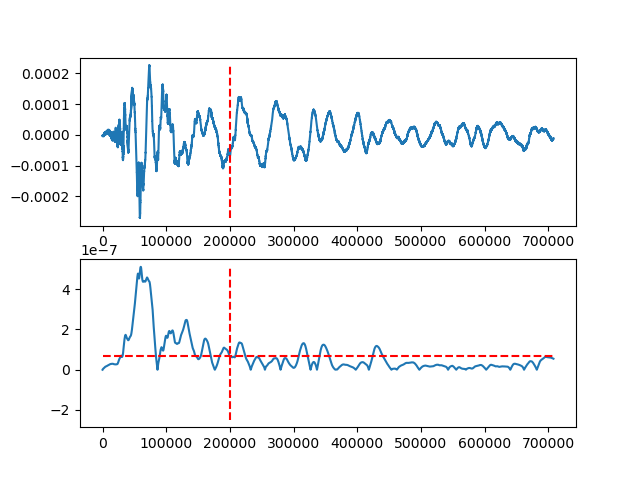

In [158]:
# tune duration estimate
keys = list(data_dict.keys())
data = data_dict[keys[130]]
env = np.abs(scipy.signal.hilbert(data))
sos = scipy.signal.butter(2,0.001, 'lp', fs=100, output='sos')
filt_env = scipy.signal.sosfilt(sos, env)
filt_env_diff = np.diff(filt_env)/(1/fs)
filt_env_diff_abs = np.abs(filt_env_diff)
peaks = scipy.signal.find_peaks(env)
thresh = np.mean(filt_env_diff_abs)
duration = len(data)-np.sum([filt_env_diff_abs<thresh])
fig,ax=plt.subplots(2,1)
ax[0].plot(data)
ax[1].plot(filt_env_diff_abs)
#plt.plot(peaks[0],env[peaks[0]])
ax[0].vlines(x=duration,ymin=np.min(data),ymax=np.max(data),color='r',linestyle='--',zorder=10)
ax[1].hlines(y=thresh,xmin=0,xmax=len(data),color='r',linestyle='--',zorder=10)
ax[1].vlines(x=duration,ymin=np.min(filt_env_diff),ymax=np.max(filt_env_diff),color='r',linestyle='--',zorder=10)
plt.show()